# <center> Unsupervised Learning Methods </center>
## <center> Problem Set III </center>
### <center> MDS, Isomap and Laplacian-Eigenmaps </center>

In [28]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [29]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

# Classical MDS
## 1.2 Implementation
Implement the following `CMDS` class:
* `FitTransform` - Given $\boldsymbol{D}_{xx}\in\mathbb{R}^{N_x\times N_x}$:
    1. Learns the encoding parameters (both training encoding and OOS encoding).
    2. Obtains a low-dimensional representation.
* `Transform` - Given $\boldsymbol{D}_{xy}\in\mathbb{R}^{N_x\times N_y}$, applies (out of sample) encoding.

**Notes:**
* $\boldsymbol{D}_{xx}[i,j] = \left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}^2$
* $\boldsymbol{D}_{xy}[i,j] = \left\Vert \boldsymbol{x}_{i}-\boldsymbol{y}_{j}\right\Vert _{2}^2$
* See Isomap lecture notes for the OOSE part.
* **Do not use any `for` (or `while`) loop!**

In [30]:
from scipy.sparse.linalg import svds

class CMDS:
    def __init__(self, d):
        self.d = d

    def FitTransform(self, mDxx):
        '''
        ===============================================================================
        Learns model's parameters
        Args:
            mDxx - Training (squared) pair-wise distances,        mDxx.shape = (Nx, Nx)
        Output:
            mZ   - Low-dimensional representation (embeddings),   mZ.shape   = (d,  Nx)
            remark: Defined in the lecture as Z = \Lambda^{1/2}_{d} \cdot V^T_{d}
        ===============================================================================
        '''

        '''
        ==============================================
        Write your code below.
        It should be ~10 lines of code
        ==============================================
        '''

        self.mDxx = mDxx
        self.mDxx_tilde = (mDxx - np.mean(mDxx, axis=0))
        self.mDxx_tilde = -0.5 * (self.mDxx_tilde - np.mean(self.mDxx_tilde, axis=1)[:, None])

        svds_values = svds(A=self.mDxx_tilde, k=self.d, which="LM")

        eigen_vectors, singular_values = svds_values[0], np.sqrt(svds_values[1])


        idx = singular_values.argsort()[::-1]
        self.mVd = eigen_vectors[:, idx]
        self.singular_values = singular_values[idx]

        mZ = np.diag(self.singular_values) @ self.mVd.T
        
        return mZ



    def Transform(self, mDxy):
        '''
        ===========================================================================================================
        Applies (out of sample) encoding
        Args:
            mDxy - (Squared) pair-wise distances between the training data and the OOS data,  mDxy.shape = (Nx, Ny)
        Output:
            mZ   - Low-dimensional representation (embeddings),                               mZ.shape   = (d,  Ny)
        ===========================================================================================================
        '''

        '''
        ==============================================
        Write your code below.
        It should be about 5-10 lines of code
        ==============================================
        '''
        k_tilde_x_y = mDxy - np.sum(self.mDxx, axis=0)[:, None] / mDxy.shape[0]
        k_tilde_x_y = -0.5 * (k_tilde_x_y - np.mean(k_tilde_x_y, axis=0))

        mZ = np.linalg.inv(np.diag(self.singular_values)) @ self.mVd.T @ k_tilde_x_y
        return mZ

# Metric MDS
## 2.3 Implementation
Implement the following `MMDS` class:
* `FitTransform` - Given $\boldsymbol{D}_{xx}\in\mathbb{R}^{N_x\times N_x}$, obtains a low-dimensional representation.

**Notes:**
* $\boldsymbol{D}_{xx}[i,j] = \left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}$ (not squared).
* Stop iterate after `maxIter` or if $\left\Vert \widetilde{\boldsymbol{Z}}^{\left(t\right)}-\boldsymbol{Z}^{\left(t\right)}\right\Vert _{F}\leq\epsilon$.
* You may initialize $\boldsymbol{Z}^{\left(0\right)}$ randomly.
* **Do not use any `for` (or `while`) loop except the main (Majorization Minimization) loop.**


In [31]:
from scipy.spatial.distance import cdist

class MMDS:
    def __init__(self, d):
        self.d = d
        
    def FitTransform(self, mDx, maxIter=500, ε=1e-6):
        '''
        =============================================================================
        Applies metric-MDS
        Args:
            mDxx - Training pair-wise distances,                mDxx.shape = (Nx, Nx)
        Output:
            mZ   - Low-dimensional representation (embeddings), mZ.shape   = (d,  Nx)
        =============================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be 10-15 lines of code
        ==============================================
        '''
        N = mDx.shape[0]
        Z_t = np.random.random((self.d, N))

        for _ in range (maxIter):
          D_z = cdist(Z_t.T, Z_t.T) 

          Z_tilde = Z_t 
          C = -np.divide(mDx, D_z, where= D_z!=0)
          C = C - np.diag(C)
          B = C - np.diag(np.sum(C, 1))

          Z_t = Z_tilde @ B / N

          if np.linalg.norm(Z_tilde - Z_t) < ε:
            break
          
          mZ = Z_t
    
        return mZ    

# Isomap
## 3.3 Implementation
Implement the following `Isomap` class:
* `FitTransform` - Given $\boldsymbol{X}\in\mathbb{R}^{d\times N_{x}}$:
    1. Learns the encoding parameters (both training encoding and OOS encoding).
    2. Applies the training encoding to $\boldsymbol{X}\in\mathbb{R}^{d\times N_{x}}$.
* `Transform` - Given $\boldsymbol{Y}\in\mathbb{R}^{d\times N_{y}}$, applies (out of sample) encoding.

**Notes:**
* You may use `sklearn.neighbors.kneighbors_graph` to construct the graph:
    * For example:
    ```python
    mG = kneighbors_graph(mX.T, K, mode='distance')
    mG = mG.maximum(mG.T) #-- Make G symmetric
    ```
    * Note the `mG` is a sparse `csr_matrix` and not `ndarray`.
* Use `scipy.sparse.csgraph.connected_components` to check if the graph is connected.  
If not, print a warning (and consider to increase the value of `K`).
* You may use `scipy.sparse.csgraph.shortest_path` to compute all-pairs shortest path.
* **Do not use any `for` (or `while`) loop!**

**Tips:**
* Use your `CMDS` class (within the `Isomap` class).
* For the `Transform` method, you may use `sklearn.neighbors.NearestNeighbors`.

In [32]:
from sklearn.neighbors    import kneighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import shortest_path, connected_components
from scipy.sparse import csr_matrix



class Isomap:
    def __init__(self, d, K):
      self.K = K
      self.d = d
      self.cmds = CMDS(self.d)
        
    def FitTransform(self, mX):
        '''
        ========================================================================
        Learns model's parameters
        Args:
            mX - Input training data,                         mX.shape = (D, Nx)
        Output:
            mZ - Low-dimensional representation (embeddings), mZ.shape = (d, Nx)
        ========================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be ~10 lines of code
        ==============================================
        '''
        self.neigh = NearestNeighbors(1)
        self.neigh.fit(mX.T)
        
        mG = kneighbors_graph(mX.T, self.K, mode='distance')
        mG = mG.maximum(mG.T) #-- Make G symmetric

        num_connected_components = connected_components(mG, directed=False, return_labels=False) > 1
        if (num_connected_components > 1):
          print("warning: graph is not connected, number od connected components is ", num_connected_components)
        
        self.dXX = shortest_path(mG, directed=False)
        mZ = self.cmds.FitTransform(self.dXX ** 2)


        return mZ
    
    def Transform(self, mY):
        '''
        ========================================================================
        Applies (out of sample) encoding
        Args:
            mY - OOS data,                                    mY.shape = (D, Ny)
        Output:
            mZ - Low-dimensional representation (embeddings), mZ.shape = (d, Ny)
        ========================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be 5-10 lines of code
        ==============================================
        '''
        distances, indices = self.neigh.kneighbors(mY.T, return_distance=True)
        dXY = self.dXX[:, indices.reshape(-1)] ** 2 + distances.T
        mZ = self.cmds.Transform(dXY)
        return mZ


# Laplacian-Eigenmaps
## 4.3 Implementation
Implement the following `LaplacianEigenmaps` class:
* `FitTransform` - Given $\boldsymbol{X}\in\mathbb{R}^{d\times N_{x}}$, obtains a low-dimensional representation.

**Notes:**
* Set $\sigma=\sigma_{\mathrm{Gain}}\cdot\mathrm{median}\left\{ \left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}\right\} $,  
where `σGain` is some number (usually, between 0.1 - 10).
* Since the graph-Laplacian $\boldsymbol{L}=\boldsymbol{D}-\boldsymbol{W}$ is SPSD use `scipy.sparse.linalg.eigsh`"
* Recall that if the graph is connected, the first eigenvector is constant and thus should be omitted.
* **Do not use any `for` (or `while`) loop!**

In [33]:
from scipy.sparse.linalg import eigsh

class LaplacianEigenmaps:
    def __init__(self, d, K):
        self.d = d
        self.K = K
        
    def FitTransform(self, mX, σGain=1):
        '''
        ========================================================================
        Learns model's parameters
        Args:
            mX - Input training data,                         mX.shape = (D, Nx)
        Output:
            mZ - Low-dimensional representation (embeddings), mZ.shape = (d, Nx)
        ==========================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be ~10 lines of code
        ==============================================
        '''
        
        sigma = np.median(cdist(mX.T, mX.T)) * σGain
        mG = kneighbors_graph(mX.T, self.K, mode='distance')
        mG = mG.maximum(mG.T).toarray() ** 2  # -- Make G symmetric
        W = np.exp(-1 * (mG / (2 * (sigma ** 2))))
        W = np.where(mG > 0, mG, 0)

        D = np.diag(np.sum(W, 1))
        L = D - W

        eigen_values, eigen_vectors = eigsh(L, which="SM", k=self.d + 1)
        idx = eigen_values.argsort()

        num_connected_components = connected_components(mG, directed=False, return_labels=False)
        if (num_connected_components == 1):
            print("LaplacianEigenmaps: the graph is connected, removing the first eigenvector")
            mZ = eigen_vectors[:, idx][:, 1:]
        else:
            mZ = eigen_vectors[:, idx][:, : -1]

        return mZ.T

from scipy.sparse.linalg import svds
## Test Your Methods
### Run the two cells below to test your implementations
#### Generate and plot data: 


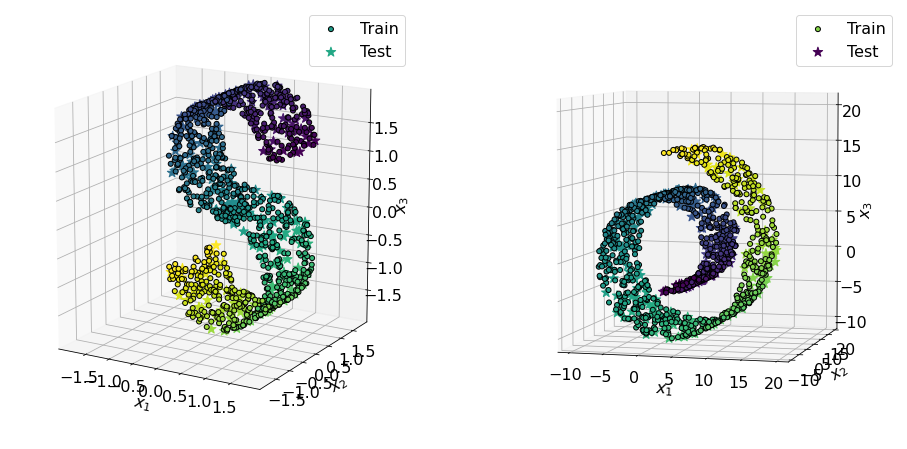

In [34]:
from sklearn.datasets     import make_s_curve, make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D 

np.random.seed(0)

def GetData(MakeData, Nx, Ny):
    mX, vCx = MakeData(Nx)
    mY, vCy = MakeData(Ny)
    
    return mX.T, mY.T, vCx, vCy
    
def PlotData(mX, mY, vCx, vCy, ax):
    m = mX.min()
    M = mX.max()
    ax.scatter(*mX, s=25,  c=vCx, edgecolor='k', alpha=1, label='Train')
    ax.scatter(*mY, s=100, c=vCy, marker='*',    alpha=1, label='Test')
    ax.set_xlim([m, M])
    ax.set_ylim([m, M])
    ax.set_zlim([m, M])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_3$')
    ax.legend()

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax1.view_init(elev=15, azim=300)
ax2.view_init(elev=5,  azim=285)

Nx = 1000
Ny = 250
mX1, mY1, vCx1, vCy1 = GetData(make_s_curve,    Nx, Ny)
mX2, mY2, vCx2, vCy2 = GetData(make_swiss_roll, Nx, Ny)
PlotData(mX1, mY1, vCx1, vCy1, ax1)
PlotData(mX2, mY2, vCx2, vCy2, ax2)

#### Apply methods:

LaplacianEigenmaps: the graph is connected, removing the first eigenvector
LaplacianEigenmaps: the graph is connected, removing the first eigenvector


<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


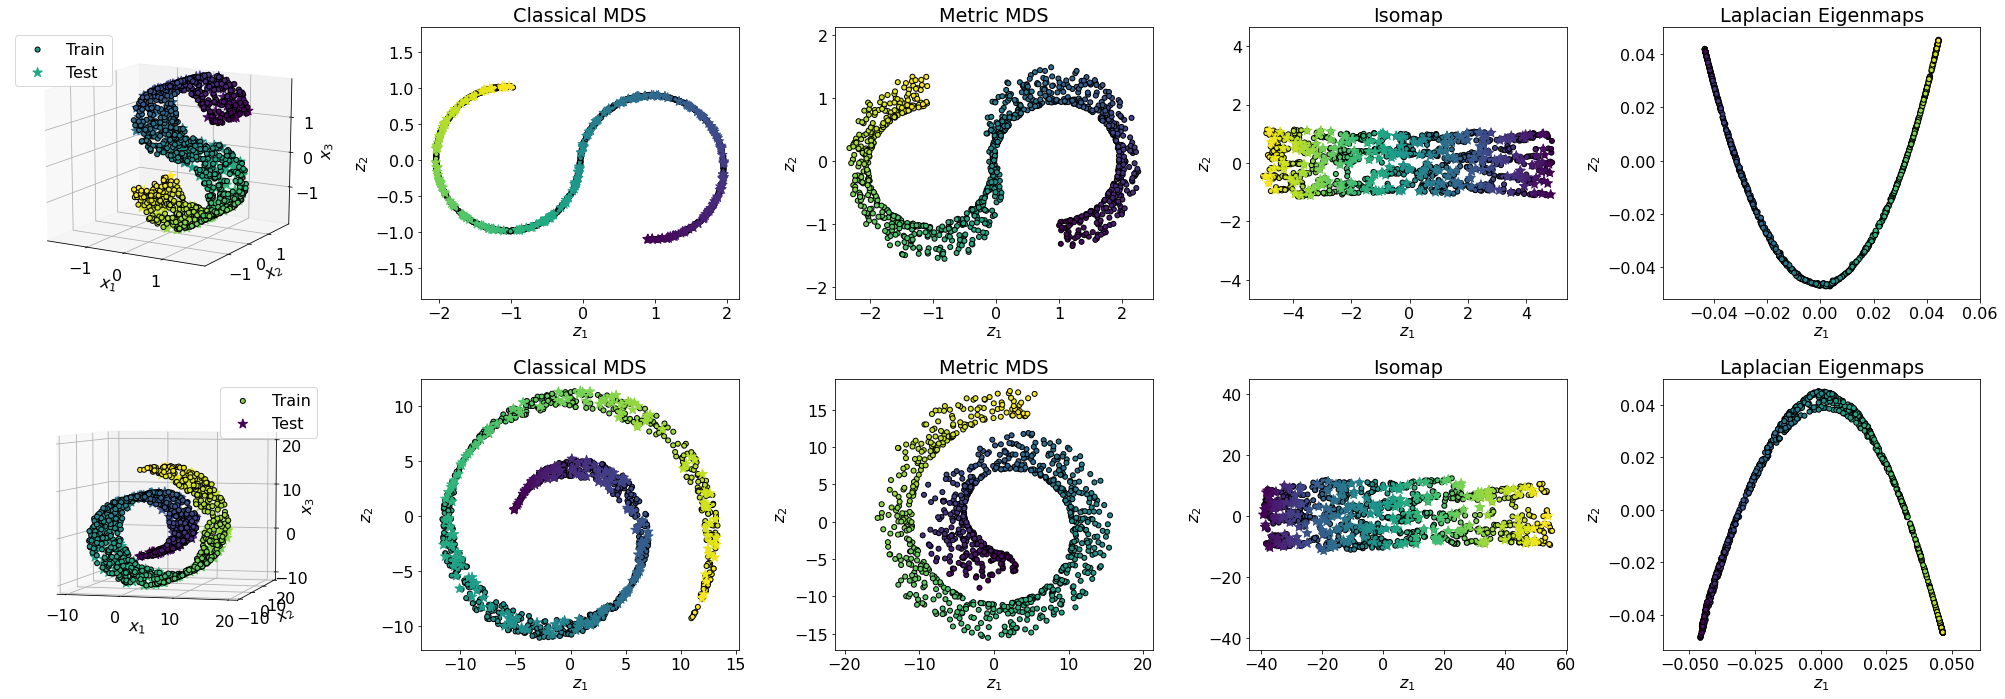

In [35]:
lData     = []
lData    += [(mX1, mY1, vCx1, vCy1)]
lData    += [(mX2, mY2, vCx2, vCy2)]

lMethods  = []
lMethods += [(CMDS              (d=2),       'Classical MDS')      ]
lMethods += [(MMDS              (d=2),       'Metric MDS')         ]
lMethods += [(Isomap            (d=2, K=8),  'Isomap')             ]
lMethods += [(LaplacianEigenmaps(d=2, K=12), 'Laplacian Eigenmaps')]

fig, mAxes = plt.subplots(2, 5, figsize=(28, 10))
for ii, (mX, mY, vCx, vCy) in enumerate(lData):
    for jj, (oMap, name) in enumerate(lMethods, 1):
        if   name == 'Classical MDS'      : mZx = oMap.FitTransform(cdist(mX.T, mX.T)**2); mZy = oMap.Transform(cdist(mX.T, mY.T)**2)
        elif name == 'Metric MDS'         : mZx = oMap.FitTransform(cdist(mX.T, mX.T))   ; mZy = np.full((2, Ny), np.nan)
        elif name == 'Isomap'             : mZx = oMap.FitTransform(mX)                  ; mZy = oMap.Transform(mY)
        elif name == 'Laplacian Eigenmaps': mZx = oMap.FitTransform(mX)                  ; mZy = np.full((2, Ny), np.nan)

        ax = mAxes[ii,jj]
        ax.scatter(*mZx, s=25,  c=vCx, edgecolor='k')
        ax.scatter(*mZy, s=100, c=vCy, marker='*')
        ax.set_xlabel('$z_1$')
        ax.set_ylabel('$z_2$')
        ax.set_title(name)
        ax.axis('equal')
    
    mAxes[ii,0].remove()
    PlotData(mX, mY, vCx, vCy, fig.add_subplot(2, 5, 1+5*ii, projection='3d'))

fig.axes[-2].view_init(elev=15, azim=300)
fig.axes[-1].view_init(elev=5,  azim=285)

plt.tight_layout()
plt.show()

## 4.4 Spectral-Clustering (5% Bonus)
Consider the following dataset:

#### Load data:

In [38]:
from scipy.io import loadmat

file = "Rings5.mat"

mX = loadmat(file)['pointCloud']
mX.shape

(3, 1000)

#### Plot data (and apply K-Means):

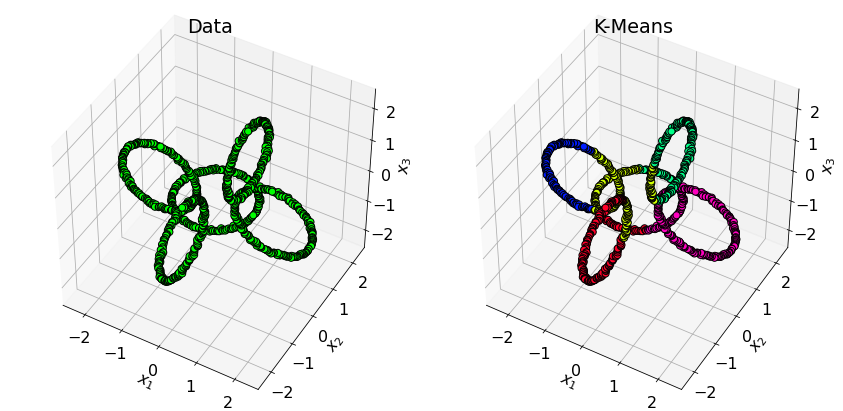

In [39]:
from sklearn.cluster import KMeans
from matplotlib.cm   import get_cmap

def PlotRings(mX, vC, title, ax):
    m = mX.min()
    M = mX.max()
    ax.scatter(*mX, s=50,  c=vC, edgecolor='k', alpha=1, cmap=get_cmap('gist_rainbow', len(np.unique(vC))))
    ax.set_xlim([m, M])
    ax.set_ylim([m, M])
    ax.set_zlim([m, M])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_3$')
    ax.view_init(elev=45, azim=300)
    ax.set_title(title)


vIdxKMeans = KMeans(5).fit_predict(mX.T)
    
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
PlotRings(mX, 'lime',     'Data',    ax1)
PlotRings(mX, vIdxKMeans, 'K-Means', ax2)


plt.tight_layout()
plt.show()

* Implement Spectral-Clustering:
    * Apply Laplacian-Eigenmaps with $d=K$, keep the first eigenvector (if it is not constant).
    * Apply K-Means, you may use `sklearn.cluster.KMeans`.
    * You might need to add one line of code to your `LaplacianEigenmaps` class.

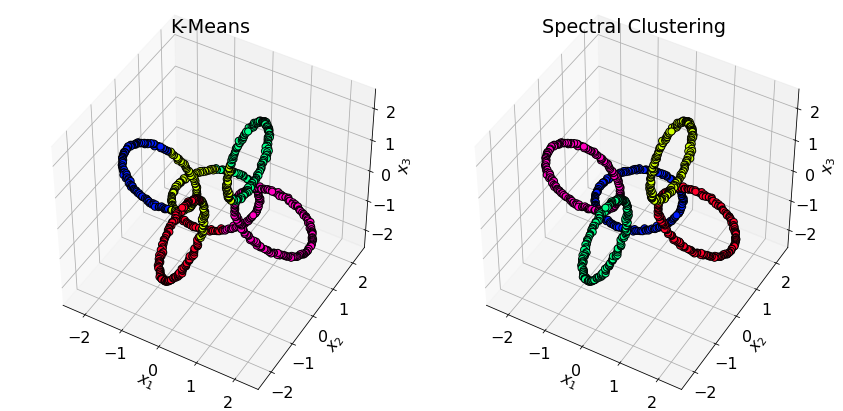

In [40]:
from sklearn.cluster import KMeans

K  = 5
'''
==============================================
Write your code below.
It should be 1-5 lines of code
==============================================
'''

mZx = LaplacianEigenmaps(d=K, K=K).FitTransform(mX) 
vIdxSC = KMeans(n_clusters=K, random_state=0).fit(mZx.T).labels_

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
PlotRings(mX, vIdxKMeans, 'K-Means',             ax1)
PlotRings(mX, vIdxSC,     'Spectral Clustering', ax2)

plt.tight_layout()
plt.show()